# Quantum Markov models
<a id="header-title-anchor"></a>
**Date**: 2023-01-25 <br>
**Author**: Emmanouil Efstathiou <br>
**Email**: manolis_ef@hotmail.com <br>

---

**MSc**: Quantum Computing and Quantum Technologies <br>
**University**: Demokritus University of Thrace <br>
**Supervisor**: Ioannis Karafillidis <br>

<div style="background-color: #E0E0E0;
            padding-right: 5px;
            padding-left: 5px;
            border-radius: 8px">
<h5>Note</h5>
<b><sup>{X}</sup></b> is a placeholder for <b>definitions</b> (created by myself) <br>
<b><sup>[Y]</sup></b> is a placeholder for <b>references</b>

## Contents
- [Code prerequisites](#code-preq-title-anchor)
- [Markov Chains](#markov-chains-title-anchor)
  - [Transitions](#transitions-subtitle-anchor)
  - [Classical Coin Flip Example](#classical-coin-flip-example-subtitle-anchor)
- [Compute Unitary Matrix](#compute-unitary-matrix-title-anchor)
- [Appendix](#appendix-title-anchor)
  - [Definitions](#definitions-subtitle-anchor)
- [References](#references-title-anchor)

## <a id="code-preq-title-anchor"> Code prerequisites

In [1]:
# Imports
import sys
from datetime import datetime
import numpy as np
from scipy.linalg import sqrtm
# Graph option 1
import networkx as nx
import matplotlib.pyplot as plt
# Graph option 2
from graphviz import Digraph

In [2]:
# Colors
RED = '\033[91m'
BLUE = '\033[94m'
YELLOW = '\033[93m'
GREEN = '\033[92m'
RESET = '\033[0m'

In [3]:
# Logging function
# Print (at least debug) logs
#   Args:
#       level: log level [debug, info, error]
#       rest of args: message
def print_log(level, *args):
    # Set debug mode
    debug = False
    # debug = True

    # Set timestamp format
    timestamp = datetime.now().strftime('%m-%d %H:%M:%S')

    # Set colors based on level
    if level == 'debug': color = YELLOW
    elif level == 'info': color = BLUE
    elif level == 'error': color = RED
    else: print_log('error', 'Invalid log level')

    # Get message
    message = ' '.join(map(str, args))
    if (level != 'debug') or (debug and level == 'debug'):
        print(f'[{timestamp}][{color}{level}{RESET}]\n{message}')

    # Exit if error
    if level == 'error': sys.exit(1)

In [4]:
# Plot function
#   Args:
#       N: matrix with all nodes, example n=('|00⟩', '|01⟩', '|10⟩', '|11⟩')
#       E: matrix with all edges, example e=(('|00⟩', '|01⟩', 1), ('|00⟩', '|10⟩', 1))
#       title: title of the plot
#   Prints plot
def plot_graph(N, E, title):
    print_log('debug', ">>> Starting function: plot_graph")
    print_log('debug', ">>> Nodes:\n", N)
    print_log('debug', ">>> Edges:\n", E)
    print_log('debug', ">>> Title:\n", title)

    # Exit if no node exists
    if not N: print_log('error', 'No node exists')

    G = nx.DiGraph()            # Create graph
    G.add_nodes_from(N)         # Add nodes
    pos = nx.planar_layout(G)   # Layout


    # Manipulate edges
    ext_edges=[]
    int_edges=[]
    for (u, v, w) in E:
        if u == v: int_edges.append((u, v, w))
        else:      ext_edges.append((u, v, w))

    # Draw nodes
    nx.draw(
        G, pos,
        with_labels=True,
        node_color='lightblue',
        edge_color='gray'
    )

    # Draw external edges
    print_log('debug', ">>> External edges:\n", ext_edges)
    if ext_edges:
        nx.draw_networkx_edges(
            G, pos,
            edgelist=ext_edges,
            edge_color='gray',
            arrows=True,
            connectionstyle='arc3, rad=0.2',
        )

    # Draw internal edges
    print_log('debug', ">>> Internal edges:\n", int_edges)
    if int_edges:
        nx.draw_networkx_edges(
            G, pos,
            edgelist=int_edges,
            edge_color='gray',
            connectionstyle='arc3, rad=0.2'
        )

    # Draw edge labels
    for (u, v, w) in E: G.add_edge(u, v, weight=w)
    edge_weights = nx.get_edge_attributes(G, 'weight')
    print_log('debug', ">>> Edge weights:\n", edge_weights)
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_weights,
        label_pos=0.3
    )

    # Show plot
    plt.title(title)
    plt.show()
    print_log('debug', ">>> Finished function: plot_graph")

## <a id="markov-chains-title-anchor"> Markov Chains
A Markov Chain
<sup>
  [[1]](#stochastic-model-ref-anchor)
  [[2]](#markov-chain-ref-anchor)
  [[3]](#markov-chain-simplified-ref-anchor)
</sup>
is a stochastic model 
<sup>
  [{1}](#stochastic-model-def-anchor)
</sup> 
where the probability of a state at time $t+1$ only depends on the state at time $t$. The states are defined by a sequence of possible probabilistic events. Markov processes are conditionally independent of the previous values of the process and, as in our case, only consider the current state. Such Markov Models Chains are called **First Order Markov Chains**.
<sup>
  [[3]](#markov-chain-simplified-ref-anchor)
</sup>
By definition:
$$ p(q_{n}|q_{1}...q_{n-1}) = p(q_{n}|q_{n-1}) $$
Markov Chains can be seperated into two types, based on their state space
<sup>
  [[2]](#markov-chain-ref-anchor)
</sup>
:
- Discrete-time (DTMC): Countable or finite state space. Each step made towards the next state is a discrete measurement. 
- Continuous-time (CTMC): Uncountable or infinite state space

### <a id="transitions-subtitle-anchor"> Transitions
The changes of the state of the system are called *transitions* and the matrix that describes the probabilities associated with each transition is called a **transition matrix**
<sup>
  [[2]](#markov-chain-ref-anchor)
</sup>
.
In a transition matrix called $A$, each element $a_{ij}$ represents the probability of transitioning from state $i$ to state $j$. Given the *conditional definition*
<sup>
  [{2}](#cond-prob-def-anchor)
</sup>
we can construct the transition matrix as follows:
<table>
  <tr><th>States</th><th>State 1</th><th>State 2</th><th>State n</th></tr>
  <tr><th>State 1</th><td>$P(State_{1}|State_{1})$</td><td>$P(State_{1}|State_{2})$</td><td>$P(State_{1}|State_{n})$</td></tr>
  <tr><th>State 2</th><td>$P(State_{2}|State_{1})$</td><td>$P(State_{2}|State_{2})$</td><td>$P(State_{2}|State_{n})$</td></tr>
  <tr><th>State n</th><td>$P(State_{n}|State_{1})$</td><td>$P(State_{n}|State_{2})$</td><td>$P(State_{n}|State_{n})$</td></tr>
</table>

The elements of the transition matrix are non-negative and must satisfy the condition that the sum of the probabilities of all transitions out of a state must be equal to one. By definition
: $\sum_{j=1}^{n} a_{ij} = 1$
<sup>
  [[3]](#markov-chain-simplified-ref-anchor)
</sup>
<br>
The Markov process must also be characterized by an *initial staste* (or initial distribution) across the state space.

### <a id="classical-coin-flip-example-subtitle-anchor"> Coin Flip Example
Here is a simple example of a coin flip Markov Chain
<sup>
 [[5]](#coin-flip-example-ref-anchor)
</sup>
where the coin can only have two states: heads (H) or tails (T). At each step, we flip the (fair, balanced) coin and produce the new state which is **H or T** with equal probability. The probability of each transition should be **$\frac{1}{2}$** and the transition matrix should look like:
$$P(H|H) = P(H|T) = P(T|H) = P(T|T) = \frac{1}{2}$$
<table>
  <tr><th>States</th><th>H</th><th>T</th></tr>
  <tr><th>H</th><td>$\frac{1}{2}$</td><td>$\frac{1}{2}$</td></tr>
  <tr><th>T</th><td>$\frac{1}{2}$</td><td>$\frac{1}{2}$</td></tr>
</table>

In [5]:
# Matrix
classical_coin_flip_matrix = np.array([[0.5, 0.5], [0.5, 0.5]])
print_log('info', 'classical_coin_flip_matrix =\n', classical_coin_flip_matrix)

[12-13 16:55:35][info]
classical_coin_flip_matrix =
 [[0.5 0.5]
 [0.5 0.5]]


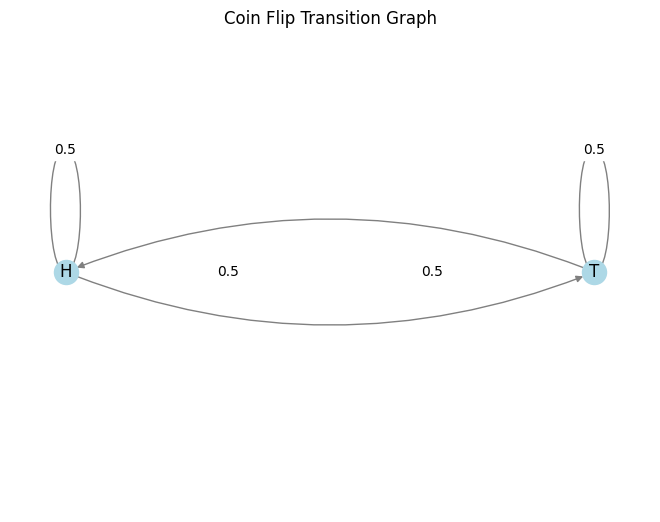

In [6]:
# Graph
nodes=['H', 'T']
edges=[('H', 'H', 0.5), ('H', 'T', 0.5),
       ('T', 'H', 0.5), ('T', 'T', 0.5)]
plot_graph(nodes, edges, 'Coin Flip Transition Graph')

## <a id="compute-unitary-matrix-title-anchor"> Compute Unitary Matrix

## General Description

This is a python programm that takes a matrix and makes it unitary based on its norm.

Matrix is **NOT** given as input, rather than it is defined here

## Instructions

The operator norm, or spectral norm is the largest singular value of A.

Singular values are the square roots of the eigenvalues of $A^{\dagger}A$

Steps:
- Compute $P=A^{\dagger}A$
- Compute the eigenvalues of $P$.
- Find the maximum eigenvalue.
- Compute the square root of the maximum eigenvalue.

Or oneliner:
$||A||_{2} = \sqrt{\lambda_{\max}(A^{\dagger}A)}$

This equals to the norm of A, which:
- If less than 1: top left corner of the matrix is $C=A/||A||_{2}$
- If greater than 1: top left corner of the matrix is $A$

So TopLeft equals A or C.
And the rest of the Unitary matrix U, equals to:
$$ U =
\begin{pmatrix}
TopLeft & \sqrt{I - TopLeft^{\dagger} TopLeft} \\\\
\sqrt{I - TopLeft TopLeft^{\dagger}} & - TopLeft^{\dagger}
\end{pmatrix}
$$

In [7]:
# Function that calculates norm of a matrix
#   Args:
#       A: Matrix
#   Returns norm of matrix A
def calc_norm(A):
    print_log('debug', ">>> Starting function: calc_norm")
    print_log('debug', ">>> Matrix input:\n", A)

    # Get conjugate of A
    A_conjugate = np.conjugate(A)
    print_log('debug', ">>> Matrix input, conjugate:\n", A_conjugate)

    # Get transpose of A conjugate
    A_dagger = np.transpose(A_conjugate)
    print_log('debug', ">>> Matrix input, transpose conjugate:\n", A_dagger)

    # Product of A_dagger and A
    P = np.dot(A_dagger, A)
    print_log('debug', ">>> Matrix input dagger @ matrix input = P:\n", P)

    # Get eigenvalues of P
    eigenvalues = np.linalg.eigvals(P)
    print_log('debug', ">>> Eigenvalues of matrix P:\n", eigenvalues)

    # Get max eigenvalue
    max_eigenvalue = np.max(eigenvalues)
    print_log('debug', ">>> Max eigenvalue of matrix P:\n", max_eigenvalue)

    # Get square root of max eigenvalue aka norm of matrix input
    norm_A = np.sqrt(max_eigenvalue)

    return norm_A

In [8]:
# Function that calculates a unitary matrix that contains a NON unitary matrix A
#   in its top left corner
#   Args:
#       A: Non unitary matrix
#   Returns unitary matrix U
def calc_unitary(A):
    print_log('debug', ">>> Starting function: calc_unitary")
    print_log('debug', ">>> Matrix input:\n", A)

    # Calculate norm of input matrix A
    norm_A = calc_norm(A)
    print_log('debug', ">>> Norm of matrix input:\n", norm_A)

    # Get number of rows/columns of A (I guess they are equal)
    n = A.shape[0]
    print_log('debug', ">>> Number of rows/columns of matrix input:\n", n)

    # Check if norm is lower or equal to 1
    if norm_A <= 1:
        # Top left corner will contain A
        top_left = A
    # Check if norm is greater than 1
    else:
        # Top left corner will contain C, which is A/norm_A
        top_left = A/norm_A

    # Calculate X_dagger@X and X@X_dagger (needed later on)
    # Where X is top left corner
    top_left_dagger = np.transpose(np.conjugate(top_left))
    top_left_x_top_left_dagger = np.dot(top_left, top_left_dagger)
    top_left_dagger_x_top_left = np.dot(top_left_dagger, top_left)
    print_log('debug', ">>> Matrix top left:\n", top_left)

    # Bottom left
    bottom_left = sqrtm(np.identity(n) - top_left_dagger_x_top_left)
    print_log('debug', ">>> Matrix left right:\n", bottom_left)

    # Top right
    top_right = sqrtm(np.identity(n) - top_left_x_top_left_dagger)
    print_log('debug', ">>> Matrix top right:\n", top_right)

    # Bottom right
    bottom_right = -top_left_dagger
    print_log('debug', ">>> Matrix bottom right:\n", bottom_right)

    # Unitary matrix U
    U = np.block([
        [top_left, top_right],
        [bottom_left, bottom_right]
        ])

    return U

In [9]:
# Validate Unitary
#   Args:
#        U: Unitary matrix
#   Returns True or False based on if U is unitary
def validate_unitary(U):
    is_unitary = False

    print_log('debug', ">>> Starting function: validate_unitary")
    print_log('debug', ">>> Matrix input:\n", U)

    # Get number of rows/columns of U (I guess they are equal)
    n = U.shape[0]
    print_log('debug', ">>> Number of rows/columns of matrix input:\n", n)

    # Check if U is unitary by computing U@U_dagger
    U_dagger = np.transpose(np.conjugate(U))
    U_dagger_x_U = np.dot(U_dagger, U)
    print_log('debug', ">>> Matrix input dagger @ matrix input:\n", U_dagger_x_U)

    # Check if U_dagger_x_U is identity matrix
    if np.allclose(U_dagger_x_U, np.identity(n)):
        print_log('debug', ">>> U is unitary")
        is_unitary = True

    return is_unitary

## Code Example 1

Non Unitary Matrix example

$$ A =
\begin{pmatrix}
2-\sqrt{2} & 0 & 0 & 0 \\\\
0 & 2\sqrt{2} & 0 & 0 \\\\
0 & 0 & \sqrt{2} & 0 \\\\
0 & 0 & 0 & 2
\end{pmatrix}
$$

In [10]:
# Define A example
A = np.array([[2-np.sqrt(2), 0, 0, 0],
              [0, 2*np.sqrt(2), 0, 0],
              [0, 0, 2*np.sqrt(2), 0],
              [0, 0, 0, 2]])
print_log('info', "Matrix A:\n", A)

[12-13 16:55:35][info]
Matrix A:
 [[0.58578644 0.         0.         0.        ]
 [0.         2.82842712 0.         0.        ]
 [0.         0.         2.82842712 0.        ]
 [0.         0.         0.         2.        ]]


In [11]:
# Calculate norm of A for a non unitary matrix
normA = calc_norm(A)
print_log('info', "Norm of matrix A:\n", normA)

[12-13 16:55:35][info]
Norm of matrix A:
 2.8284271247461903


In [12]:
# Calculate unitary matrix for a non unitary matrix
U = calc_unitary(A)
print_log('info', "Unitary matrix U, calculated from not-unitary matrix A:\n", U)

[12-13 16:55:36][info]
Unitary matrix U, calculated from not-unitary matrix A:
 [[ 0.20710678  0.          0.          0.          0.97831834  0.
   0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.70710678  0.          0.
   0.          0.70710678]
 [ 0.97831834  0.          0.          0.         -0.20710678 -0.
  -0.         -0.        ]
 [ 0.          0.          0.          0.         -0.         -1.
  -0.         -0.        ]
 [ 0.          0.          0.          0.         -0.         -0.
  -1.         -0.        ]
 [ 0.          0.          0.          0.70710678 -0.         -0.
  -0.         -0.70710678]]


/tmp/ipykernel_151276/312715929.py:35: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  bottom_left = sqrtm(np.identity(n) - top_left_dagger_x_top_left)
/tmp/ipykernel_151276/312715929.py:39: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  top_right = sqrtm(np.identity(n) - top_left_x_top_left_dagger)


### **Warning**
Since the norm of matrix A is higher than one, the resulting unitary matrix U contains
$C = A/norm(A)$ in its top left corner (not A)

In [13]:
# Top left corner should contain:
print_log('info', "Matrix A/norm(A) = C:\n", A/normA)

[12-13 16:55:36][info]
Matrix A/norm(A) = C:
 [[0.20710678 0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         0.70710678]]


In [14]:
# Validate Unitary
is_unitary = validate_unitary(U)
print_log('info', "Is U unitary?:\n", is_unitary)

[12-13 16:55:36][info]
Is U unitary?:
 True


## Code Example 2 (Pennylane)

https://pennylane.ai/qml/demos/tutorial_intro_qsvt

Non Unitary Matrix example

$$ B =
\begin{pmatrix}
0.1 & 0.2 \\\\
0.3 & 0.4
\end{pmatrix}
$$

In [15]:
# Oneliners example for B:
B = np.array([[0.1, 0.2],
              [0.3, 0.4]])
print_log('info', "Matrix B:\n", B)
print_log('info', "Unitary U that contains B in top left corner:\n", calc_unitary(B))
print_log('info', "Is U unitary ?:\n", validate_unitary(calc_unitary(np.array([[0.1, 0.2],
                                                                               [0.3, 0.4]]))))

[12-13 16:55:36][info]
Matrix B:
 [[0.1 0.2]
 [0.3 0.4]]
[12-13 16:55:36][info]
Unitary U that contains B in top left corner:
 [[ 0.1         0.2         0.97283788 -0.05988708]
 [ 0.3         0.4        -0.05988708  0.86395228]
 [ 0.94561648 -0.07621992 -0.1        -0.3       ]
 [-0.07621992  0.89117368 -0.2        -0.4       ]]
[12-13 16:55:36][info]
Is U unitary ?:
 True


# Markov Models

Create a Markov Model with a non-unitary matrix N, then create a unitary matrix U that contains N in its top left corner.

## Graph transitions, Slides example [Matplotlib and Networkx]

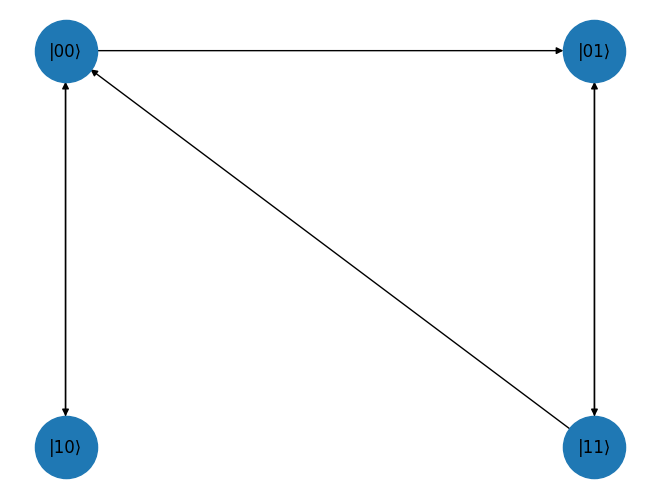

In [16]:
# Slides example
G = nx.DiGraph()
edges = [
        ('|00⟩', '|01⟩'),
        ('|00⟩', '|10⟩'),
        ('|01⟩', '|11⟩'),
        ('|10⟩', '|00⟩'),
        ('|11⟩', '|00⟩'),
        ('|11⟩', '|01⟩')
]
G.add_edges_from(edges)

pos = {
    '|00⟩': (-1, 1),
    '|01⟩': (1, 1),
    '|10⟩': (-1, -1),
    '|11⟩': (1, -1)
}
nx.draw(G, pos, with_labels=True,
        node_size=2000, arrows=True)
plt.show()

In [17]:
# ## Graph transitions, Slides example [Graphviz]
# g = Digraph('States', format='png', engine='dot')
#
# # Node style
# g.attr('node', shape='circle')
#
# # Nodes
# g.node('00', '|00⟩')
# g.node('01', '|01⟩')
# g.node('10', '|10⟩')
# g.node('11', '|11⟩')
#
# # Edges
# g.edge('00', '01')
# g.edge('00', '11')
# g.edge('01', '11')
# g.edge('10', '00')
# g.edge('11', '00')
# g.edge('11', '01')
# g

## Matrix transitions, Slides example

Extract the matrix out of the possible transitions presented in the graph.

Node |00⟩ has two equally possible options: |01⟩ and |10⟩, so transitions equal:

$|00⟩ \rightarrow \frac{1}{\sqrt{2}}(|01⟩ + |10⟩)$

Similarly for all the other nodes:

$|01⟩ \rightarrow |11⟩$

$|10⟩ \rightarrow |00⟩$

$|11⟩ \rightarrow \frac{1}{\sqrt{2}}(|00⟩ - |01⟩)$

So the next superposition state is:
$$|q_{t+1}⟩ = \frac{\sqrt{2}-1}{\sqrt{2}}|00⟩ + \frac{2}{\sqrt{2}}|01⟩ + \frac{1}{\sqrt{2}}|10⟩ + |11⟩$$

And for starting state:
$$|q_{t}⟩ = \frac{1}{2}(|00⟩ + |01⟩ + |10⟩ + |11⟩)$$

The matrix should look like this:
$$B =
\begin{pmatrix}
\frac{2(\sqrt{2}-1)}{\sqrt{2}} & 0 & 0 & 0 \\\\
0 & \frac{4}{\sqrt{2}} & 0 & 0 \\\\
0 & 0 & 2\sqrt{2} & 0 \\\\
0 & 0 & 0 & 2 \\\\
\end{pmatrix}$$

Because $|q_{t+1}⟩ = B|q_{t}⟩$ and
$$|q_{t}⟩ =
\begin{pmatrix}
\frac{1}{2} \\\\
\frac{1}{2} \\\\
\frac{1}{2} \\\\
\frac{1}{2} \\\\
\end{pmatrix}$$

In [18]:
# Matrix representation, Slides example
# Define Matrix B slides example
B = np.array([
    [ 2*(np.sqrt(2)-1)/np.sqrt(2),  0,              0,              0],
    [ 0,                            4/np.sqrt(2),   0,              0],
    [ 0,                            0,              2*np.sqrt(2),   0],
    [ 0,                            0,              0,              2]
])
print_log('info', "Matrix B:\n", B)

[12-13 16:55:36][info]
Matrix B:
 [[0.58578644 0.         0.         0.        ]
 [0.         2.82842712 0.         0.        ]
 [0.         0.         2.82842712 0.        ]
 [0.         0.         0.         2.        ]]


In [19]:
# Is matrix B unitary? Lets validate:
validate_unitary(B)

False

In [20]:
# Since B is not Unitary, lets calculate a unitary matrix that contains B in its top left corner
UB = calc_unitary(B)
print_log('info', "Matrix UB:\n", UB)
print_log('info', "Is Matrix UB Unitary?:\n", validate_unitary(UB))

[12-13 16:55:36][info]
Matrix UB:
 [[ 2.07106781e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   9.78318343e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.49011612e-08  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  7.07106781e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  7.07106781e-01]
 [ 9.78318343e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.07106781e-01 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  1.49011612e-08  0.00000000e+00  0.00000000e+00
  -0.00000000e+00 -1.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -1.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 

/tmp/ipykernel_151276/312715929.py:35: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  bottom_left = sqrtm(np.identity(n) - top_left_dagger_x_top_left)
/tmp/ipykernel_151276/312715929.py:39: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  top_right = sqrtm(np.identity(n) - top_left_x_top_left_dagger)


Since UB is unitary, we can now perform calculation to obtain next state
$|q_{t+1}⟩ = UB|q_{t}⟩$

## <a id="appendix-title-anchor"> Appendix
### <a id="definitions-subtitle-anchor"> Definitions
- <a id="stochastic-model-def-anchor"></a>{1}
  *Stochastic Model*
  <sup>[[1]](#stochastic-model-ref-anchor)</sup>
  :<br>
  A mathematical object that consists of a family of random variables in a probability space, all of which are associated with an index set. The index set often has the interpretation of time. Example stochastic models are Markov chains, Bernouli processes, Poisson processes. <br>
- <a id="cond-prob-def-anchor"></a>{2}
  *Conditional Probability*
  <sup>[[4]](#bayes-rule-ref-anchor)</sup>
  :<br>
  The probability of event *i* occuring given that event *j* has already occured. <br>

## <a id="references-title-anchor"> References
- <a id="stochastic-model-ref-anchor"></a>[1]
  <a href="https://en.wikipedia.org/wiki/Stochastic_process">
  Stochastic Model
- <a id="markov-chain-ref-anchor"></a>[2]
  <a href="https://en.wikipedia.org/wiki/Markov_chain">
  Markov Chain
- <a id="markov-chain-simplified-ref-anchor"></a>[3]
  <a href="https://www.gaussianwaves.com/2020/03/markov-chains-simplified/">
  Markov chains simplified
- <a id="bayes-rule-ref-anchor"></a>[4]
  <a href="https://en.wikipedia.org/wiki/Bayes%27_theorem">
  Bayes' Theorem
- <a id="coin-flip-example-ref-anchor"></a>[5]
  <a href="https://phys.libretexts.org/Bookshelves/Mathematical_Physics_and_Pedagogy/Computational_Physics_(Chong)/12%3A_Markov_Chains/12.01%3A_The_Simplest_Markov_Chain-_The_Coin-Flipping_Game">
  Coin Flipping Game

<a href="#header-title-anchor">Back to Top</a>